# Content <a id='back'></a>

* [Introduction](#)
* [1. Prepare the Data](#)
     * [1. 1 Open the File and Study the Data](#)
     * [1. 2 Check if the gold gain has been calculated correctly and Find the MAE](#)
     * [1. 3 Analysis of features that are not available in the test set. What are these parameters](#)
     * [1. 4 Perform data pre-processing](#)
* [2. EDA](#)
     * [2. 1 How the concentration of metals (Au, Ag, Pb) changes depending on the stage of purification](#)
     * [2. 2 Compare the particle size distribution of the feed in the training set and in the test set](#)
* [3. CBuild the Model](#)
     * [3. 1 Calculating the final sMAPE score](#)
     * [3. 2 Conduct training on different models. Evaluation of these models using cross-validation](#)
* [Conclusions](#)

</a>

# Introduction <a id='Pendahuluan'></a>

Set up a prototype machine learning model for Zyfra. The company is engaged in developing efficient solutions for heavy industry.

Our model should be able to predict the amount of gold extracted or recovered from gold ore. There is data related to the process of extracting and refining gold ore that you can use.

Later, this model is expected to help create a more efficient production process and get rid of non-profitable parameters.

We need to:
- Prepare available data;
- Carry out data analysis;
- Develop and train models.

Data Description :

Process Technology
- Rougher feed — raw material for flotation process
- Rougher additions (or reagent additions) — reagents for flotation: Xanthate, Sulphate, Depressant
  - Xanthate — flotation activator or activator
  - Sulphate — sodium sulfide, specifically for this process
  - Depressant — sodium silicate
- Rougher process — flotation
- Rougher tails — product residue
- Float banks — flotation units
- Cleaner process — purification
- Rougher Au — coarser gold concentrate
- Final Au — final gold concentrate

Parameters of Available Stages
- air amount — air volume
- fluid levels
- feed size — the size of the feed particles
- feed rates

Feature Naming
Here's how to give names to existing features:
- [stage].[parameter_type].[parameter_name]
- Example: rougher.input.feed_ag

Possible values ​​for [stage]:
- rougher — flotation
- primary_cleaner — first purification
- secondary_cleaner — second purification
- final — final characteristics

Possible values ​​for [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — a parameter indicating the characteristics of the current stage
- calculation — characteristic calculation

## Prepare the data<a id='langkah1'></a>

### open File and Study the Data <a id='1.1'></a>

In [1]:
#Import Modul Data Preprocessing and Manipulation
import pandas as pd
import numpy as np

#Import Modul ML
from sklearn.preprocessing import StandardScaler

#Import Modul Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Read Data
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
#Check Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
#Check Shape
df_train.shape, df_test.shape, df_full.shape

((16860, 87), (5856, 53), (22716, 87))

In [7]:
#Data Validation
df_full[df_full['date'].isin(df_train['date'])].shape, df_full[df_full['date'].isin(df_test['date'])].shape

((16860, 87), (5856, 87))

In [8]:
#Check Duplicate
df_train.duplicated().sum(), df_test.duplicated().sum(), df_full.duplicated().sum()

(0, 0, 0)

In [9]:
#Check percentage Null
100 * round(df_train.isnull().sum().mean()/len(df_train),2), 100 * round(df_test.isnull().sum().mean()/len(df_test),2), 100 * round(df_full.isnull().sum().mean()/len(df_full),2)

(2.0, 1.0, 2.0)

In [10]:
#Dataframe
df_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [11]:
df_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the data reading steps above, the following information can be obtained:
- df_train comes from gold_recovery_train
  - There are 16860 rows, 87 columns
  - Data contains final.output(concentrate, recovery, tail), primary_cleaner(input, output, state), rougher(calculation, input, output, state), dan secondary_cleaner(output, state)
  - Null values ​​amount to ~2%
  - No duplicate values
- df_test comes from gold_recovery_test
  - There are 5856 rows, 53 columns
  - Data contains primary_cleaner(input, state), rougher(input, state), secondary_cleaner(state)
  - Null values ​​add up to ~1%
  - No duplicate values
- df_full comes from gold_recovery_full
  - There are 22716 rows, 87 columns
  - Data contains a mix of df_train and df_test
  - Null values ​​amount to ~2%
  - No duplicate values

</div>

### Check if the gold gain has been calculated correctly. Find the MAE between your calculation and the feature value. <a id='1.2'></a>

In [12]:
df_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

In [13]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [14]:
df_train['recovery_calc'] = (C * (F - T)) / (F * (C - T)) * 100

In [15]:
df_train['recovery_calc'] 

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: recovery_calc, Length: 16860, dtype: float64

In [16]:
MAE = (df_train['recovery_calc'] - df_train['rougher.output.recovery']).abs().mean()
MAE

9.303415616264301e-15

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The gold recovery has been calculated correctly because in the example in df_train column rougher.output.recovery with recovery_calc the calculation is the same.
MAE (Mean Absolute Error) has also been calculated which produces a value of 9.303415616264301e-15 or around 0.0

</div>

### Analysis of features that are not available in the test set. What are these parameters? What type are these parameters? <a id='1.3'></a>

In [17]:
#missing_test_col = list(set(df_train.columns)-set(df_test.columns))
missing_test_col = set(list(df_train.columns.values))-set(list(df_test.columns.values))
missing_test_col

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery_calc',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
There are some columns in df_train but no df_test. Judging from the list above, the pattern for stage and parameter_type that doesn't exist is as follows:
- final. output
- primary_cleaner
- rougher. calculation
- rougher. output
- secondary_cleaner
     
Everything is in the metals Ag, Au, PB, and Sol.
</div>

### Pre-Processing <a id='1.4'></a>

In [18]:
#df_train.isnull().mean().sort_values(ascending=False)

In [19]:
#df_test.isnull().mean().sort_values(ascending=False)

In [20]:
#df_full.isnull().mean().sort_values(ascending=False)

In [21]:
df_train.isnull().sum().mean()/len(df_train)

0.021974414968187212

In [22]:
df_test.isnull().sum().mean()/len(df_test)

0.007603876688318384

In [23]:
df_full.isnull().sum().mean()/len(df_test)

0.07181356384649205

In [24]:
#df_new_train = df_train.fillna(df_train.median())
#df_new_train.reset_index(drop=True, inplace=True)

#df_new_test = df_test.fillna(df_test.median())
#df_new_test.reset_index(drop=True, inplace=True)

def fill_missing_values(df):
    df = df.fillna(method='ffill', axis=0, inplace=True)
    
df_new_train = df_train.copy()
df_new_test = df_test.copy()

fill_missing_values(df_new_train)
fill_missing_values(df_new_test)
fill_missing_values(df_full)
    

In [25]:
df_new_train['date'] = pd.to_datetime(df_new_train['date'])
df_new_test['date'] = pd.to_datetime(df_new_test['date'])

In [26]:
df_train.shape, df_test.shape, df_full.shape

((16860, 88), (5856, 53), (22716, 87))

In [27]:
df_new_train.shape, df_new_test.shape

((16860, 88), (5856, 53))

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Fill in the null values using the filll method (The fill() method replaces the NULL values with the value from the previous row (or previous column, if the axis parameter is set to 'columns'). In addition, a new dataframe is created, namely df_new_train and df_new_test.
</div>

## Data Analytics<a id='langkah2'></a>

### How the concentration of metals (Au, Ag, Pb) changes depending on the stage of purification.

In [28]:
metals = ['au', 'ag', 'pb']
stage_parameter = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
xcolors = ['green', 'orange', 'dodgerblue']

# function to plot distribution of concentrations
def plot_distribution(df):
    for element in metals:
        plt.figure(figsize=(10,6), dpi=80)
        for features, colour in zip(stage_parameter, xcolors):
            sns.histplot(df[features+'_'+element], color=colour, label=features+'_'+element, kde=True, stat='density')
            plt.axvline(0, c="r")
        plt.title('Distribution of ' +element+ ' concentrations across purification stage')
        plt.xlabel('Concentration of '+element)
        plt.legend();
        plt.show()

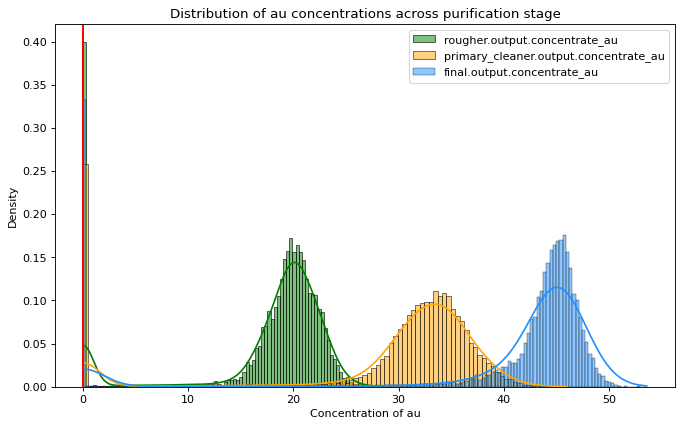

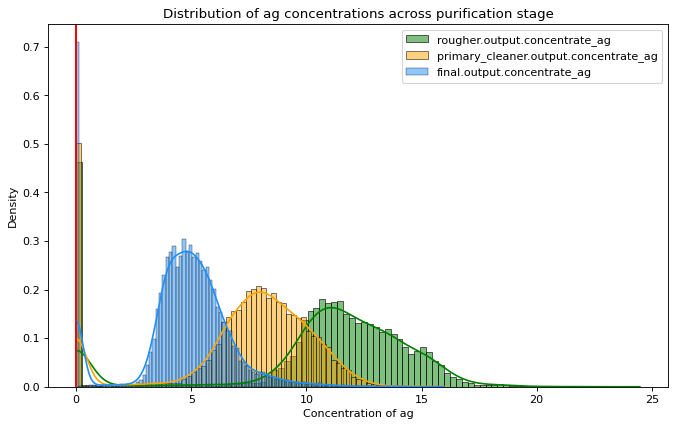

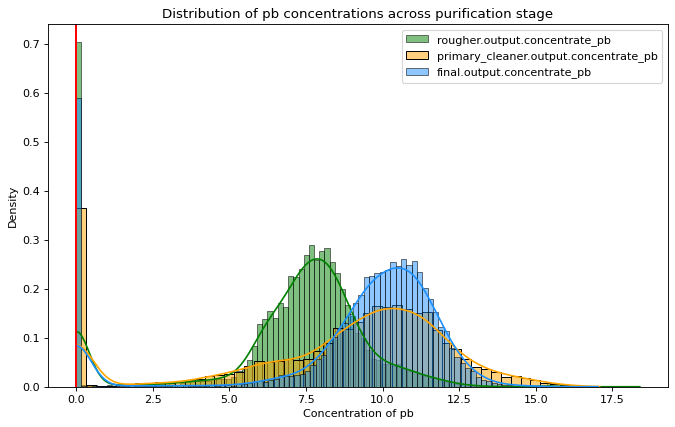

In [29]:
plot_distribution(df_new_train)

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
- For au(Gold) metal concentration increases from rougher.output to final.output
- For ag and pb metal concentration decreased from rougher.output to final.output
</div>

### Compare the particle size distribution of the feed in the training set and in the test set. If the distribution varies significantly, the evaluation of the model will be erroneous.

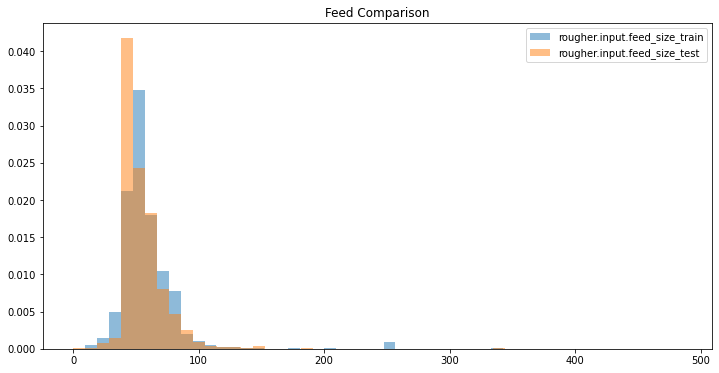

In [30]:
plt.figure(figsize=(12,6))
plt.hist(df_new_train['rougher.input.feed_size'],bins=50,label='rougher.input.feed_size_train',alpha=.5, density=1)
plt.hist(df_new_test['rougher.input.feed_size'],bins=50,label='rougher.input.feed_size_test',alpha=.5, density=1)
plt.legend()
plt.title('Feed Comparison');

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Distribution of feedsize particles in df_train and df_test is not much different. Because If the distribution varies significantly, the evaluation of the model will be wrong.
</div>

### Consider the total concentrations of all substances at different stages: raw feed, coarser concentrations, and final concentrations. Do you notice any abnormal values in the distribution of the totals? If yes, is it necessary to remove those values from both samples? Describe what you found and rule out the anomaly.

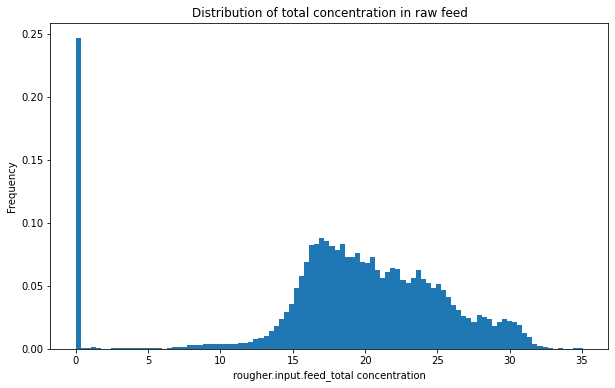

In [31]:
# Check the Abnormal Rougher Input Feed Value
df_full['rougher.input.feed.total_concentration'] = df_full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
dist_rougher_input = df_full['rougher.input.feed.total_concentration']
plt.figure(figsize=(10,6))
plt.hist(dist_rougher_input, density=True, bins=100)
plt.xlabel('rougher.input.feed_total concentration')
plt.ylabel('Frequency')
plt.title("Distribution of total concentration in raw feed");

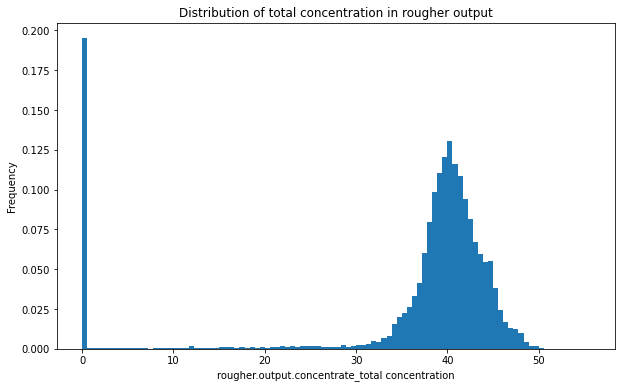

In [32]:
#Check Abnormal Rougher Output Concentrate Value
df_full['rougher.output.concentrate.total_concentration'] = df_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
dist_rougher_output = df_full['rougher.output.concentrate.total_concentration']
plt.figure(figsize=(10,6))
plt.hist(dist_rougher_output, density=True, bins=100)
plt.xlabel('rougher.output.concentrate_total concentration')
plt.ylabel('Frequency')
plt.title("Distribution of total concentration in rougher output");

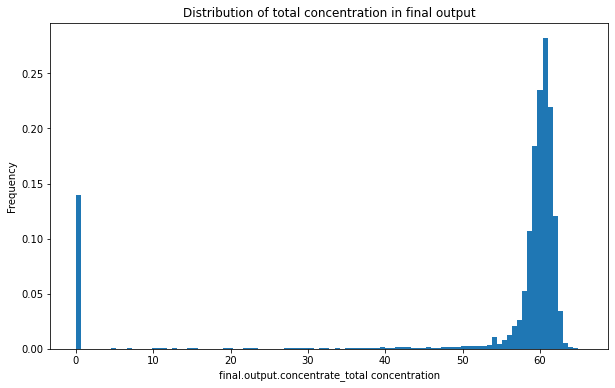

In [33]:
#Check Abnormal Rougher Output Concentrate Value
df_full['final.output.concentrate.total_concentration'] = df_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)
dist_final_output = df_full['final.output.concentrate.total_concentration']
plt.figure(figsize=(10,6))
plt.hist(dist_final_output, density=True, bins=100)
plt.xlabel('final.output.concentrate_total concentration')
plt.ylabel('Frequency')
plt.title("Distribution of total concentration in final output");

In [34]:
# filtered data without outliers
df_full_data = df_full[(df_full['rougher.input.feed.total_concentration'] > 0.5) & 
                                        (df_full['rougher.output.concentrate.total_concentration'] > 0.5) & 
                                        (df_full['final.output.concentrate.total_concentration'] > 0.5)]
print('The shape of the new dataset is: ', format(df_full_data.shape))
print()
df_full_data.describe()

The shape of the new dataset is:  (19902, 90)



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.input.feed.total_concentration,rougher.output.concentrate.total_concentration,final.output.concentrate.total_concentration
count,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,...,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000,19902.000000
mean,5.250819,10.006565,9.438465,44.027825,67.277514,9.723405,2.695955,10.405661,3.059784,143.981146,...,-461.784524,15.670838,-488.681469,12.217803,-487.182682,18.941750,-505.444580,20.705129,40.004043,59.285209
std,1.426818,1.573364,2.881576,4.672312,9.608592,2.396083,0.980537,3.040803,0.971515,45.811760,...,66.676666,5.510947,35.461950,5.307293,39.198545,5.541093,38.856178,4.677070,4.807175,5.203063
min,0.000000,0.135894,0.000000,0.225775,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464,1.130990,0.618497,0.744251
25%,4.278353,9.147051,7.630848,43.276171,63.351612,8.077242,2.023195,8.763335,2.463881,113.362163,...,-500.186940,10.988126,-500.458101,8.977904,-500.130105,14.983477,-500.739252,17.227306,38.480772,59.224695
50%,5.108622,10.105502,9.192000,44.936486,68.236471,9.810351,2.739689,10.527450,2.996826,143.085493,...,-499.473279,14.997691,-499.793089,11.021120,-499.934137,19.955408,-500.047655,20.210281,40.389264,60.262110
75%,5.952204,11.043697,10.969755,46.231836,72.742253,11.218110,3.344934,12.029183,3.588549,175.268756,...,-400.144262,18.025599,-498.347963,14.017513,-499.431331,23.992897,-499.481106,23.989323,42.490172,61.065867
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,265.983123,...,-7.834746,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459,35.071987,55.568687,65.575259


/tmp/ipykernel_250/55852927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_data['rougher.input.feed.total_concentration'] = df_full_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)


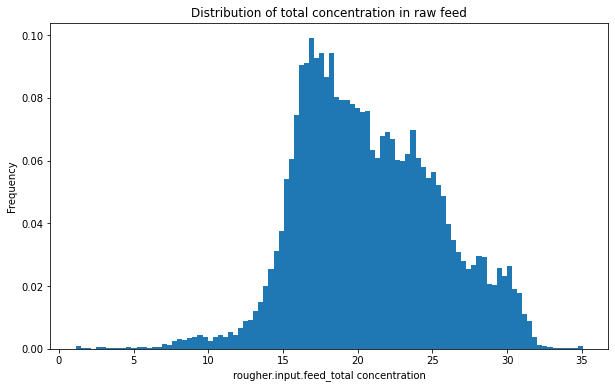

In [35]:
# Check again whether there are still outliers
df_full_data['rougher.input.feed.total_concentration'] = df_full_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
dist_rougher_input = df_full_data['rougher.input.feed.total_concentration']
plt.figure(figsize=(10,6))
plt.hist(dist_rougher_input, density=True, bins=100)
plt.xlabel('rougher.input.feed_total concentration')
plt.ylabel('Frequency')
plt.title("Distribution of total concentration in raw feed");

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the first three histograms above, there are outliers around the number 0 at all concentrations. In order to make the modeling more accurate, it is necessary to remove outlier values ​​with a threshold above 0.5.
</div>

In [36]:
df_full_data['date'] = pd.to_datetime(df_full_data['date'])

/tmp/ipykernel_250/94353416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_data['date'] = pd.to_datetime(df_full_data['date'])


In [37]:
# make date column the index in dataset
df_new_test.set_index('date', inplace=True)
df_new_train.set_index('date', inplace=True)
df_full_data.set_index('date', inplace=True)

In [38]:
# index of train set in full dataset
df_new_train_data_index = df_full_data.index.intersection(df_new_train.index)
df_new_train_data_index.shape

(14613,)

In [39]:
# new train dataset
df_new_train_data = df_full_data.loc[df_new_train_data_index]
df_new_train_data.reset_index(inplace=True)
#df_new_train_data.head()

In [40]:
# index of test set in full dataset
df_new_test_data_index = df_full_data.index.intersection(df_new_test.index)
df_new_test_data_index.shape

(5289,)

In [41]:
# new test dataset
df_new_test_data = df_full_data.loc[df_new_test_data_index]
df_new_test_data.reset_index(inplace=True)
#df_new_test_data.head()

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The use of set indexes df_train, df_new_train, and df_full based on date because the date value is quite unique down to the second.
</div>

## Build the Model <a id='langkah3'></a>

### Calculating the final sMAPE score

In [45]:
# function to compute the sMAPE
def smape(y_true, y_pred):
    smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()
    return smape

# function to calculate the final sMAPE value
def smape_final(y_true, y_pred):
    smape_out_rougher = smape(y_true[:,0], y_pred[:,0])
    smape_out_final = smape(y_true[:,1], y_pred[:,1])
    return ((0.25 * smape_out_rougher) + (0.75 * smape_out_final))

#user-defined scoring function
smape_score = make_scorer(smape_final)

In [46]:
# declare variables for features and target
features_train = df_new_train_data.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = df_new_test_data.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = df_new_train_data[['rougher.output.recovery', 'final.output.recovery']]
target_test = df_new_test_data[['rougher.output.recovery', 'final.output.recovery']]


In [47]:
target_train.columns = [0, 1]
target_test.columns = [0, 1]

In [48]:
# features scaling
scaler = StandardScaler()
scaler.fit(features_train)

# transform the training set and the test set using transform()
features_train = scaler.transform(features_train)
features_test  = scaler.transform(features_test)

# target data as numpy array
target_train = target_train.values
target_test = target_test.values

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
The function has been created and is ready to be used on df_test. Targets for train and test have been determined, namely rougher.output.recovery and final.output.recovery. For features, namely columns other than target plus date.
</div>

###  Conduct training on different models. Evaluate the models using cross validation. Choose the best model and test the model using a test sample or test sample.

In [49]:
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor # import dummy regressor

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer

In [50]:
# baseline model using a dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_regr_test_predictions = dummy_regr.predict(features_test)

In [51]:
smape_final(target_test, dummy_regr_test_predictions)

0.08306002052413737

In [52]:
#LinearRegression
lr_regr = LinearRegression().fit(features_train, target_train) # train the model 
lr_regr_test_predictions = lr_regr.predict(features_test)

# cross-validation for linear model
cv_score_lr = cross_val_score(lr_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.2%}'.format(cv_score_lr.mean()))
print('sMAPE range of values are: ', cv_score_lr)
# compute final smape for linear regression
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, lr_regr_test_predictions)))

Mean smape:  4.55%
sMAPE range of values are:  [0.05361309 0.03550464 0.04223571 0.03866229 0.05740168]
The final sMAPE score is: 3.05%


In [53]:
#RandomForestRegression
rf_regr = RandomForestRegressor().fit(features_train, target_train) # train the model 
rf_regr_test_predictions = rf_regr.predict(features_test)

# cross-validation for random forest regression
cv_score_rf = cross_val_score(rf_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.2%}'.format(cv_score_rf.mean()))
print('sMAPE range of values are: ', cv_score_rf)
# compute final smape for random forest
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, rf_regr_test_predictions)))

Mean smape:  3.12%
sMAPE range of values are:  [0.04577028 0.0241414  0.02398129 0.02633457 0.03573369]
The final sMAPE score is: 1.90%


In [54]:
#DecisionTreeRegresison
dt_regr = DecisionTreeRegressor().fit(features_train, target_train) # train the model 
dt_regr_test_predictions = dt_regr.predict(features_test)

# cross-validation for decision tree regression
cv_score_dt = cross_val_score(dt_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.4%}'.format(cv_score_dt.mean()))
print('sMAPE range of values are: ', cv_score_dt)
# compute final smape for decision tree model
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, dt_regr_test_predictions)))

/tmp/ipykernel_250/3184498818.py:3: RuntimeWarning: invalid value encountered in true_divide
  smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()
/tmp/ipykernel_250/3184498818.py:3: RuntimeWarning: invalid value encountered in true_divide
  smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()
/tmp/ipykernel_250/3184498818.py:3: RuntimeWarning: invalid value encountered in true_divide
  smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()


Mean smape:  nan%
sMAPE range of values are:  [       nan 0.04244928        nan        nan 0.06027031]
The final sMAPE score is: nan%


/tmp/ipykernel_250/3184498818.py:3: RuntimeWarning: invalid value encountered in true_divide
  smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()


<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Data modeling was carried out using the LinearRegression, RandomForestRegression, and DecisionTreeRegression models.
In addition, an evaluation was also carried out using the cross-validation method.
The best final SMAPE score calculation is RandomForrestRegressor with a value of ~1.8%. Better than the other 2 models.
However, it also takes the longest time.
</div>

## Conclusions <a id='kesimpulan'></a>

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the data reading steps above, the following information can be obtained:
- df_train comes from gold_recovery_train
  - There are 16860 rows, 87 columns
  - Data contains final_output(concentrate, recovery, tail), primary_cleaner(input, output, state), rougher(calculation, input, output, state), and secondary_cleaner(output, state)
  - Null values amount to ~2%
  - No duplicate values
- df_test comes from gold_recovery_test
  - There are 5856 rows, 53 columns
  - Data contains primary_cleaner(input, state), rougher(input, state), secondary_cleaner(state)
  - Null values add up to ~1%
  - No duplicate values
- df_full comes from gold_recovery_full
  - There are 22716 rows, 87 columns
  - Data contains a mix of df_train and df_test
  - Null values amount to ~2%
  - No duplicate values

The gold recovery has been calculated correctly because in the example in df_train column rougher.output.recovery with recovery_calc the calculation is the same.
For au(Gold) the metal concentration increased from rougher.output to final.output than the other 2 metals namely ag and pb.
The distribution of feedsize particles in df_train and df_test is not much different. Because If the distribution varies significantly, the evaluation of the model will be wrong.
The best final SMAPE score calculation is RandomForrestRegressor with a value of ~1.8%. Better than the other 2 models.
However, it also takes the longest time. If the goal is to find the best value regardless of the time it takes, using RandomForrestRegressor is recommended.
And if time is considered fast, two other models can be chosen.


</div>